In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt
# from tqdm import tqdm
import random
# import cv2
import PIL
import os
plt.style.use('ggplot')

In [3]:
def salt_and_pepper(img, p):
    '''
    Adds "salt and pepper" noise to an image.
    p (between 0 and 1) percent of the pixels are changed to be either
    black or white with an equal liklihood of either
    '''

    if p < 0 or p > 1:
        raise ValueError("p should be between 0 and 1")

    assert(type(img) == torch.Tensor)
    img_copy = img.clone().numpy()

    n = int(p * img_copy.size)
    indices_to_change = np.random.choice(img_copy.size, n, replace=False)
    random_values = np.random.randint(0, 2, n)
    img_copy.flat[indices_to_change] = random_values

    return torch.from_numpy(img_copy).reshape(1, img.shape[0], img.shape[1])

In [17]:
class DenoisingDataset(Dataset):
    def __init__(self, root_dir, transform=None, noise=0.05):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.noise = noise

        # images and labels are the same, images are just noisy
        self.images = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = None

        with open(image_path, 'rb') as f:
            image = PIL.Image.open(f)
            if self.transform:
                image = self.transform(image)
                label = image.clone() # clear image is the label
                image = salt_and_pepper(image.squeeze(),self.noise) # add noise

        return image, label


In [18]:
# Resize, grayscale, convert to tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
])

batch_size = 50
train_loader = DataLoader(
    DenoisingDataset(root_dir="./datasets/sports/train/", transform=transform, noise=0.08),
    batch_size=batch_size,
    shuffle=True
)

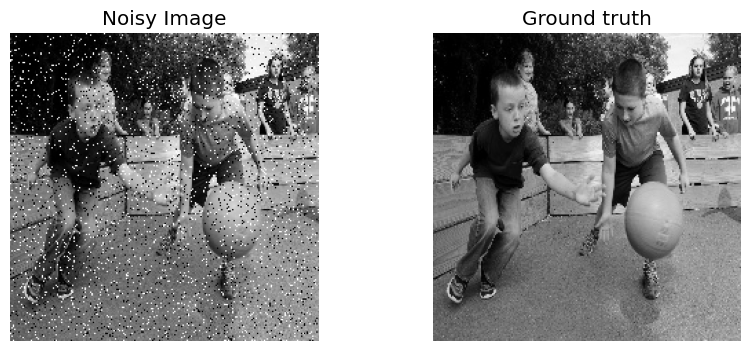

In [19]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# get a random noisy image and label (ground truth) from the batch
idx = np.random.randint(0, batch_size)  # Choose a random index within the batch
image = images[idx]
label = labels[idx]
image = image.squeeze().numpy()
label = label.squeeze().numpy()

# show image and ground truth
fig, ax = plt.subplots(1,2, figsize=(10,4));
ax[0].imshow(image, cmap="gray");
ax[0].set_title("Noisy Image")
ax[0].axis('off');
ax[1].imshow(label, cmap="gray");
ax[1].set_title("Ground truth")
ax[1].axis('off');
